### ANÁLISIS DE SERIES DE TIEMPO (VARIACIÓN DE VALOR DE DIFERENTES MONEDAS)

Considerando un dataset extraído de la api "oanda", que contiene el histórico de la variación por hora del valor de diferentes pares de monedas (EUR-USD, AUD-USD, etc), se propone lo siguiente: 

* Desarrollar un modelo ARIMA que permita predecir el precio de las monedas en días futuros (forecasting). 
sólo para una moneda por ejemplo, Euro - Dólar.



* Desarrollar un modelo ARMA que permita predecir el precio de las monedas en días futuros (forecasting). 

* Desarrollar un modelo de clasificación para determinar regímenes de mercado.  

## 1. Lectura del Dataframe 

In [42]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
import os
import math 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')
from pmdarima import auto_arima   

In [4]:
datos = pd.read_csv(r'AUD_USD_H1.csv',index_col= 'time')
print(f'El dataframe que se construye con las variaciones de cotización de moneda está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

datos.head(5)

El dataframe que se construye con las variaciones de cotización de moneda está compuesto por 8 columnas y 50000 filas


,open_bid,high_bid,low_bid,close_bid,open_ask,high_ask,low_ask,close_ask
time,,,,,,,,
2015-01-27 08 PM,0.79375,0.79524,0.79347,0.79383,0.79393,0.79549,0.79366,0.79405
2015-01-27 09 PM,0.79382,0.79382,0.79265,0.79344,0.79405,0.79405,0.79287,0.79402
2015-01-27 10 PM,0.79338,0.79364,0.79243,0.79250,0.79385,0.79413,0.79283,0.79283
2015-01-27 11 PM,0.79256,0.79304,0.79184,0.79197,0.79290,0.79333,0.79204,0.79219
2015-01-28,0.79197,0.80024,0.78991,0.79930,0.79216,0.80055,0.79017,0.79952


In [5]:
datos.shape

(50000, 8)

* Descripción del Dataframe.

* time: Hora en de apertura para cada periodo.

open_bid : Precio de apertura para la venta  a la hora indicada. 

high_bid : Precio más alto de venta del usuario para esa hora. 

low_bid : Precio más bajo de venta del usuario para esa hora.

close_bid: Precio de cierre para la venta a la hora indicada.

open_ask : Precio de apertura para la compra a la hora indicada. 

high_ask : Precio más alto de compra para el usuario para esa hora. 

low_ask : Precio más bajo de compra para usuario para esa hora.

close_ask : Precio de cierre para la compra a la hora indicada.

In [4]:
# Lista de todos los .csv de datos 
path = os.getcwd() 
files = [os.path.join(path, file) for file in os.listdir(path) if '.csv' in file]

# Generación de DataFrame
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# Colocar columna time como índice del DataFrame
df.index = df.time

# Eliminar columna y definición de DataFrame a utilizar
datos = df.drop(['time'], axis = 1)
datos.head()

,open_bid,high_bid,low_bid,close_bid,open_ask,high_ask,low_ask,close_ask
time,,,,,,,,
2015-01-27 08 PM,0.79375,0.79524,0.79347,0.79383,0.79393,0.79549,0.79366,0.79405
2015-01-27 09 PM,0.79382,0.79382,0.79265,0.79344,0.79405,0.79405,0.79287,0.79402
2015-01-27 10 PM,0.79338,0.79364,0.79243,0.79250,0.79385,0.79413,0.79283,0.79283
2015-01-27 11 PM,0.79256,0.79304,0.79184,0.79197,0.79290,0.79333,0.79204,0.79219
2015-01-28,0.79197,0.80024,0.78991,0.79930,0.79216,0.80055,0.79017,0.79952


In [6]:
datos.shape

(50000, 8)

* Calcular con todas las monedas el retorno (precio actual - precio del pasado), y luego de ello construir una regresión lineal buscando discernir si el retorno de varias monedas (features) logra explicar el retorno de una combinación de moneda (target)

## Construcción modelo ARIMA

# Variación Dolar Euro

In [2]:
datos = pd.read_csv(r'EUR_USD_H1.csv')
print(f'El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

#print(datos_euro_dolar.head())

df = datos[['open_bid', 'time']]
df.head()


El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por 9 columnas y 50000 filas


,open_bid,time
0,1.13343,2015-01-28 02 AM
1,1.13335,2015-01-28 03 AM
2,1.13399,2015-01-28 04 AM
3,1.13358,2015-01-28 05 AM
4,1.13544,2015-01-28 06 AM


In [3]:
df['time'] = pd.to_datetime(df['time'])
df_ARIMA = df.set_index("time")
df_ARIMA
#df_ARIMA = df.drop(['time'], axis = 1)

C:\Users\mpire\AppData\Local\Temp\ipykernel_11064\733901518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


,open_bid
time,
2015-01-28 02:00:00,1.13343
2015-01-28 03:00:00,1.13335
2015-01-28 04:00:00,1.13399
2015-01-28 05:00:00,1.13358
2015-01-28 06:00:00,1.13544
...,...
2023-02-09 21:00:00,1.07328
2023-02-09 22:00:00,1.07345
2023-02-09 23:00:00,1.07392


In [4]:
# Resample del DataFrame , calculando open_bid promedio por día. 

exchange_rate_1 = df_ARIMA.resample('D').agg({'open_bid':'mean'})


In [5]:
exchange_rate_1

,open_bid
time,
2015-01-28,1.133460
2015-01-29,1.130125
2015-01-30,1.131697
2015-01-31,NaN
2015-02-01,1.130895
...,...
2023-02-06,1.076015
2023-02-07,1.072053
2023-02-08,1.073121


In [6]:
# Para conocer la distribución de los datos 
exchange_rate_1.describe()

,open_bid
count,2507.000000
mean,1.127024
std,0.053879
min,0.961805
25%,1.094516
50%,1.124703
75%,1.168910
max,1.248688


In [8]:
# Para saber si existen valores nulos
exchange_rate_1.isnull().sum()

open_bid    429
dtype: int64

In [7]:
# Eliminar valores nulos 
exchange_rate = exchange_rate_1.dropna()

In [14]:
exchange_rate.shape

(2507, 1)

In [9]:
exchange_rate.isnull().sum()

open_bid    0
dtype: int64

In [25]:
fig = px.line(exchange_rate, x = exchange_rate.index, y = exchange_rate.open_bid, template = "plotly_dark",
            title = 'Variación de precio de apertura entre EUR y USD')
fig.show()

In [1]:
%pip install streamlit

     ---------------------------------------- 9.6/9.6 MB 11.8 MB/s eta 0:00:00
     --------------------------------------- 20.6/20.6 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 813.6/813.6 kB 12.8 MB/s eta 0:00:00
     ---------------------------------------- 82.0/82.0 kB 2.3 MB/s eta 0:00:00
     -------------------------------------- 164.8/164.8 kB 9.7 MB/s eta 0:00:00
     ------------------------------------- 904.0/904.0 kB 11.5 MB/s eta 0:00:00
     -------------------------------------- 184.3/184.3 kB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 4.7/4.7 MB 12.0 MB/s eta 0:00:00
     ------------------------------------- 238.7/238.7 kB 15.2 MB/s eta 0:00:00
     ---------------------------------------- 55.8/55.8 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB 3.3 MB/s eta 0:00:00
     ---------------

In [ ]:
fig, ax = plt.subplot(figsize = (10,3))
exchange_rate.boxplot(column='open_bid', by  ='time', ax= ax, color = 'yellow')
exhan

In [27]:
returns = (exchange_rate/exchange_rate.shift(1))
returns = returns.iloc[1:]
returns

,open_bid
time,
2015-01-29,0.997057
2015-01-30,1.001392
2015-02-01,0.999291
2015-02-02,1.001413
2015-02-03,1.005804
...,...
2023-02-06,0.997705
2023-02-07,0.996318
2023-02-08,1.000996


array([[<AxesSubplot: title={'center': 'open_bid'}>]], dtype=object)

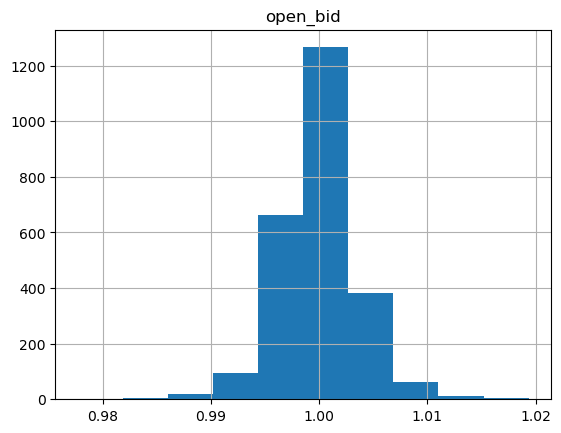

In [28]:
returns.hist()

<AxesSubplot: xlabel='time'>

<Figure size 1000x900 with 0 Axes>

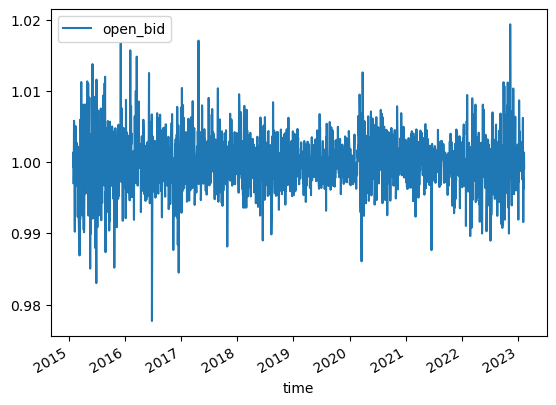

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
returns.plot()

In [18]:
len(exchange_rate)

2507

In [87]:
# Usaremos el 70% de los datos para train y el restante para test. 

training_data, testing_data = train_test_split(exchange_rate, test_size=0.3, random_state=42, shuffle=False)

particion_datos = int(len(exchange_rate)*0.7)

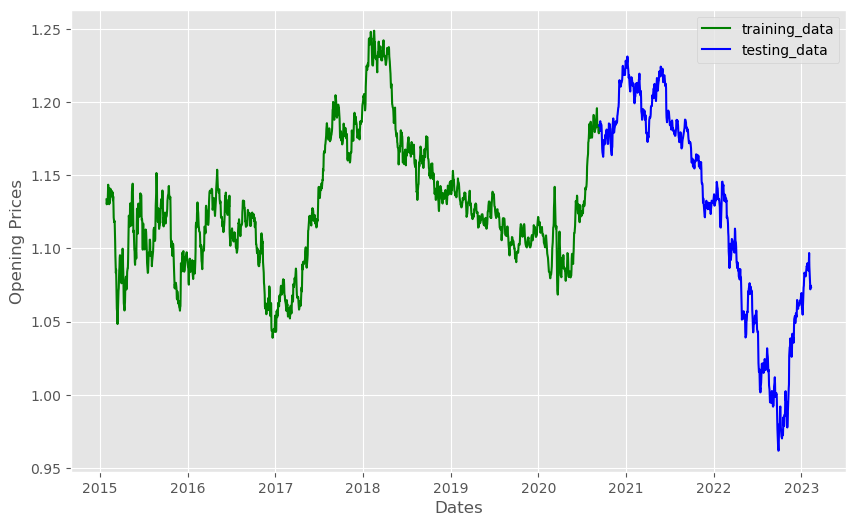

In [47]:
# Para ver gráficamente los datos de train y test

plt.figure(figsize=(10,6))
plt.grid=(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(training_data['open_bid'], 'green', label = 'training_data')
plt.plot(testing_data['open_bid'], 'blue', label = 'testing_data')
plt.legend()

In [48]:
test_data = list(testing_data['open_bid'])
train_data = list(training_data['open_bid'])

In [16]:
print(len(test_data))

753


## Para elegir p, d y q
* p: The number of lag observations included in the model, also called the lag order. 
* d: The number of times the raw observartion are differenced, also called the degree of differencing. 
* q: The size of the moving average window, also called the order of moving average. 


In [20]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(exchange_rate['open_bid'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.054386
p-value: 0.263247
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### p-value mayor a 0.05 significa que la hipótesis nula no puede ser rechazada y esta serie puede ser tomada como no estacionaria. Por lo que tenemos que aplicar alguna metodología para volver la serie estacionaria.

### En primer lugar vamos a diferenciar y luego aplicar nuevamente el test de Dickey Fuller

In [21]:
exchange_rate_2 =exchange_rate.copy()
# Take first difference
exchange_rate_2['open_bid_diff'] = exchange_rate_2['open_bid'].diff()

# Remove the first data point
exchange_rate_2.dropna(inplace=True)

# Take a look at the head of the dataset
exchange_rate_2.head()

,open_bid,open_bid_diff
time,,
2015-01-29,1.130125,-0.003335
2015-01-30,1.131697,0.001573
2015-02-01,1.130895,-0.000802
2015-02-02,1.132493,0.001598
2015-02-03,1.139066,0.006572


In [23]:
result = adfuller(exchange_rate_2['open_bid_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.035784
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### p-value menor a 0.05 significa que la hipótesis nula puede ser rechazada y esta serie puede ser tomada como estacionaria.

In [27]:
fig = px.line(df, x=exchange_rate_2.index, y=exchange_rate_2.open_bid_diff ,template = "plotly_dark",
              title = 'Variación de precio de apertura entre EUR y USD - 1st Diff')
fig.show()

In [35]:
exchange_rate_2.isnull().sum()

open_bid         0
open_bid_diff    0
dtype: int64

### Al diferenciar la serie se vuelve estacional , presenta menor varianza alrededor del 0. 

## Encontrando valor de parámetro "d"

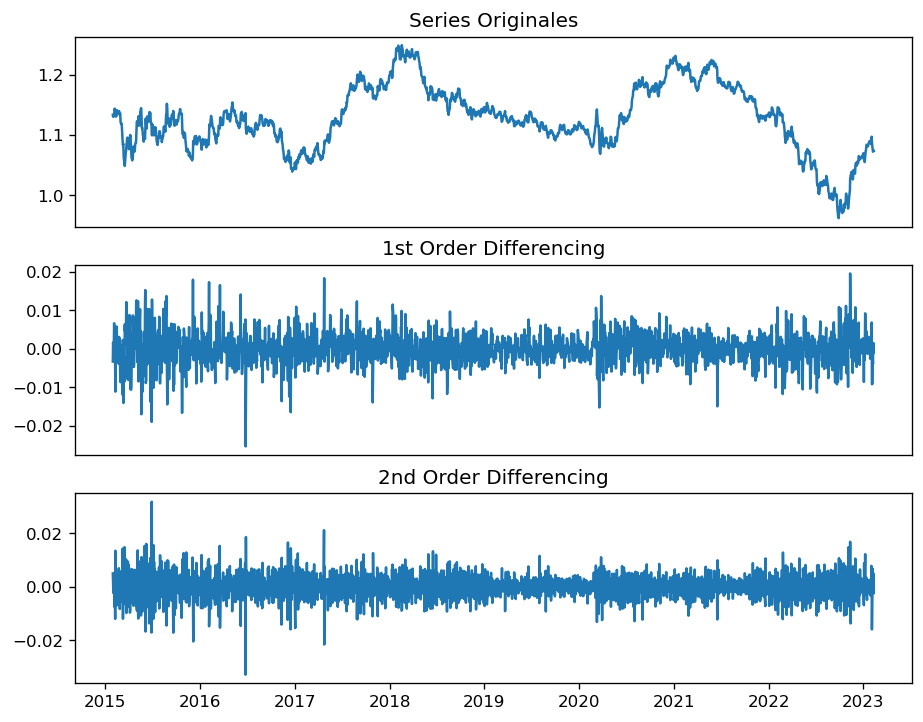

In [36]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Serie original
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(exchange_rate.open_bid); ax1.set_title('Series Originales'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(exchange_rate.open_bid.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(exchange_rate.open_bid.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

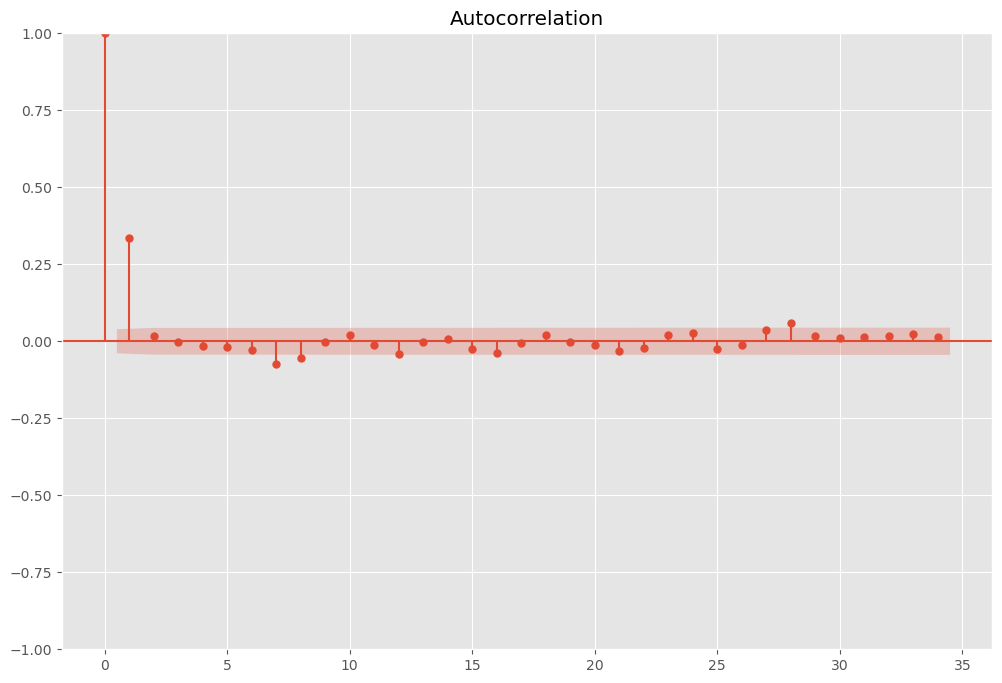

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots()
plot_acf(exchange_rate_2.open_bid_diff, ax = ax);
# plot_acf(exchange_rate.open_bid.diff().dropna(), ax=ax2)
# plot_acf(exchange_rate.open_bid.diff().diff().dropna(), ax=ax3)

## Encontrando valor de parámetro "p"

Hay mucha periodicidad en esta serie tiempo, lo que supone un valor para alto para "p". 
Esto se puede corroborar haciendo un gráfico de autocorrelación 

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



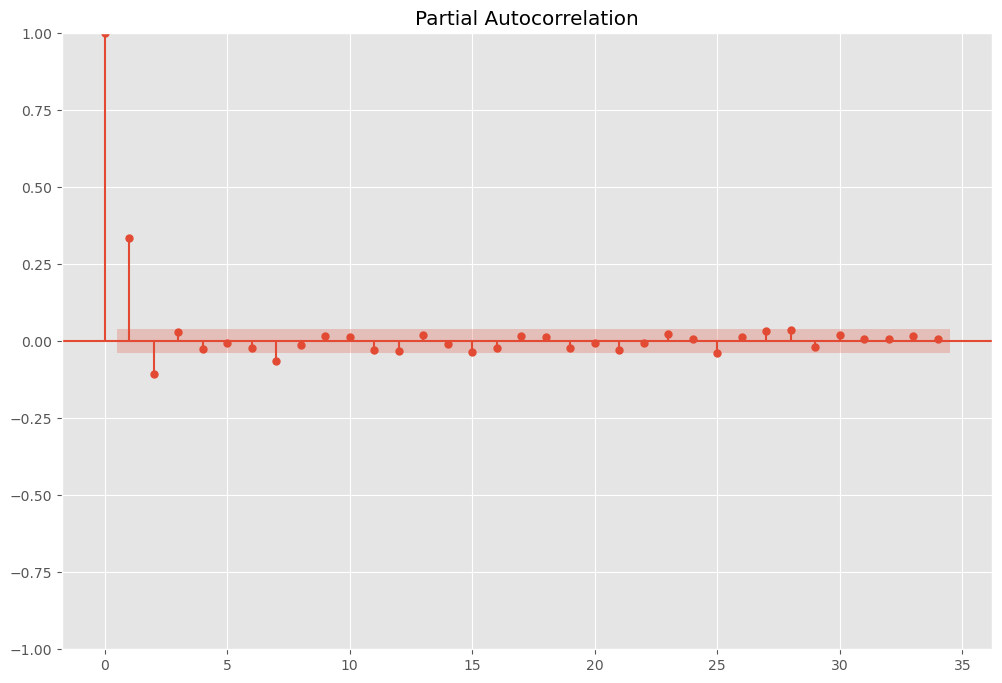

In [38]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(exchange_rate_2.open_bid.diff().dropna());

### Podría ser 0 el valor de "p" o  p = 3

### Modelo Auto-Arima

        Ejecutemos la función auto_arima() para obtener los mejores parametros de p,d,q,P,D,Q

Nota: El parámetro se refiere al número de periodo para cada estacionalidad

        * 7 para los días
        * 12 para los meses
        * 52 para las semanas
        * 4 Trimestral
        * 1 Anual

In [95]:
modelo_auto = auto_arima(training_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-12918.475, Time=1.35 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-13708.494, Time=1.79 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-14180.840, Time=4.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-13129.603, Time=0.82 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-14249.850, Time=4.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-13718.468, Time=1.01 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-14041.981, Time=7.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-14246.127, Time=13.55 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-14236.211, Time=6.20 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-13900.348, Time=9.28 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-14214.343, Time=24.94 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-13868.745, Time=2.70 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=10.63 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=13.74 sec
 

In [68]:
print(modelo_auto.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1754
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                7128.925
Date:                            Wed, 22 Mar 2023   AIC                         -14249.850
Time:                                    10:47:17   BIC                         -14228.001
Sample:                                01-31-2015   HQIC                        -14241.771
                                     - 09-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3072      0.018     17.066      0.000       0.272       0.342
ar.S.L12      -0.0419      0.025   

In [88]:
training_data.index.dtype
training_data.index = pd.DatetimeIndex(training_data.index).to_period('D')

In [89]:
training_data.index

PeriodIndex(['2015-01-28', '2015-01-29', '2015-01-30', '2015-02-01',
             '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05',
             '2015-02-06', '2015-02-08',
             ...
             '2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03',
             '2020-09-04', '2020-09-06', '2020-09-07', '2020-09-08',
             '2020-09-09', '2020-09-10'],
            dtype='period[D]', name='time', length=1754)

### Implementación del modelo

In [90]:
arima_model = SARIMAX(training_data["open_bid"], order = (0,1,1), seasonal_order = (1,1,1,12)) 
arima_result = arima_model.fit() 
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           open_bid   No. Observations:                 1754
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                7128.925
Date:                            Wed, 22 Mar 2023   AIC                         -14249.850
Time:                                    11:20:49   BIC                         -14228.001
Sample:                                01-28-2015   HQIC                        -14241.771
                                     - 09-10-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3072      0.018     17.066      0.000       0.272       0.342
ar.S.L12      -0.0419      0.025     -1.699      0.089      -0.090       0.006
ma.S.L12      -0.8418      0.019    -43.883      0.000      -0.879      -0.804
sigma2      1.603e-05   3.46e-07     46.320      0.000    1.54e-05    1.67e-05
===================================================================================
Ljung-Box (L1) (Q):                   3.49   Jarque-Bera (JB):               635.65
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
arima_result

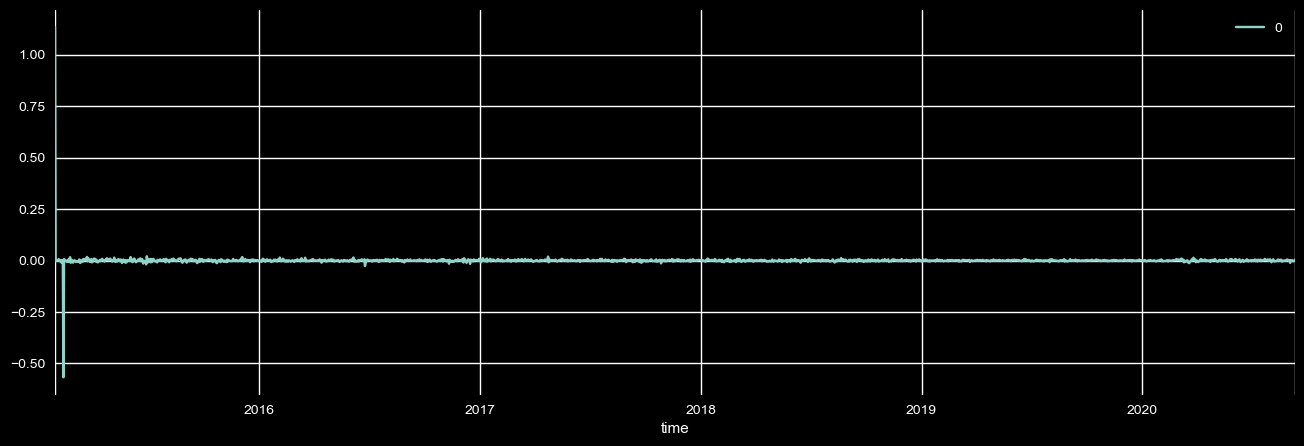

In [97]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5));
plt.show();

In [96]:
modelo_auto.

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

C:\Users\mpire\AppData\Local\Temp\ipykernel_11064\2378803206.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



TypeError: float() argument must be a string or a real number, not 'Period'

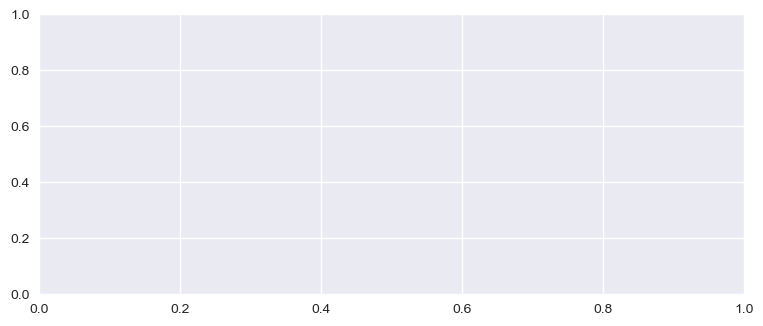

In [92]:
plt.style.use('seaborn')
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

Entonces, ¿cómo interpretar los diagnósticos de la trama?

Arriba a la izquierda: los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme.

Arriba a la derecha: la gráfica de densidad sugiere una distribución normal con media cero.

Abajo a la izquierda: todos los puntos deben estar perfectamente alineados con la línea roja. Cualquier desviación significativa implicaría que la distribución está sesgada.

Abajo a la derecha: el correlograma, también conocido como gráfico ACF, muestra que los errores residuales no están autocorrelacionados. Cualquier autocorrelación implicaría que existe algún patrón en los errores residuales que no se explican en el modelo. Por lo tanto, deberá buscar más X (predictores) en el modelo.

En general, parece encajar bien. Pronostiquemos.

In [101]:
# arima_pred= arima_result.predict(start=training_data.shape[0],end=(training_data.shape[0]+testing_data.shape[0]-1), dynamic=False)
arima_pred= arima_result.predict(start = len(train_data), end = len(exchange_rate)-1, typ="levels").rename("ARIMA Predictions")

arima_pred

2019-11-17    1.186124
2019-11-18    1.185974
2019-11-19    1.187065
2019-11-20    1.189378
2019-11-21    1.190121
                ...   
2021-12-04    1.625415
2021-12-05    1.623833
2021-12-06    1.623067
2021-12-07    1.622613
2021-12-08    1.624038
Freq: D, Name: ARIMA Predictions, Length: 753, dtype: float64

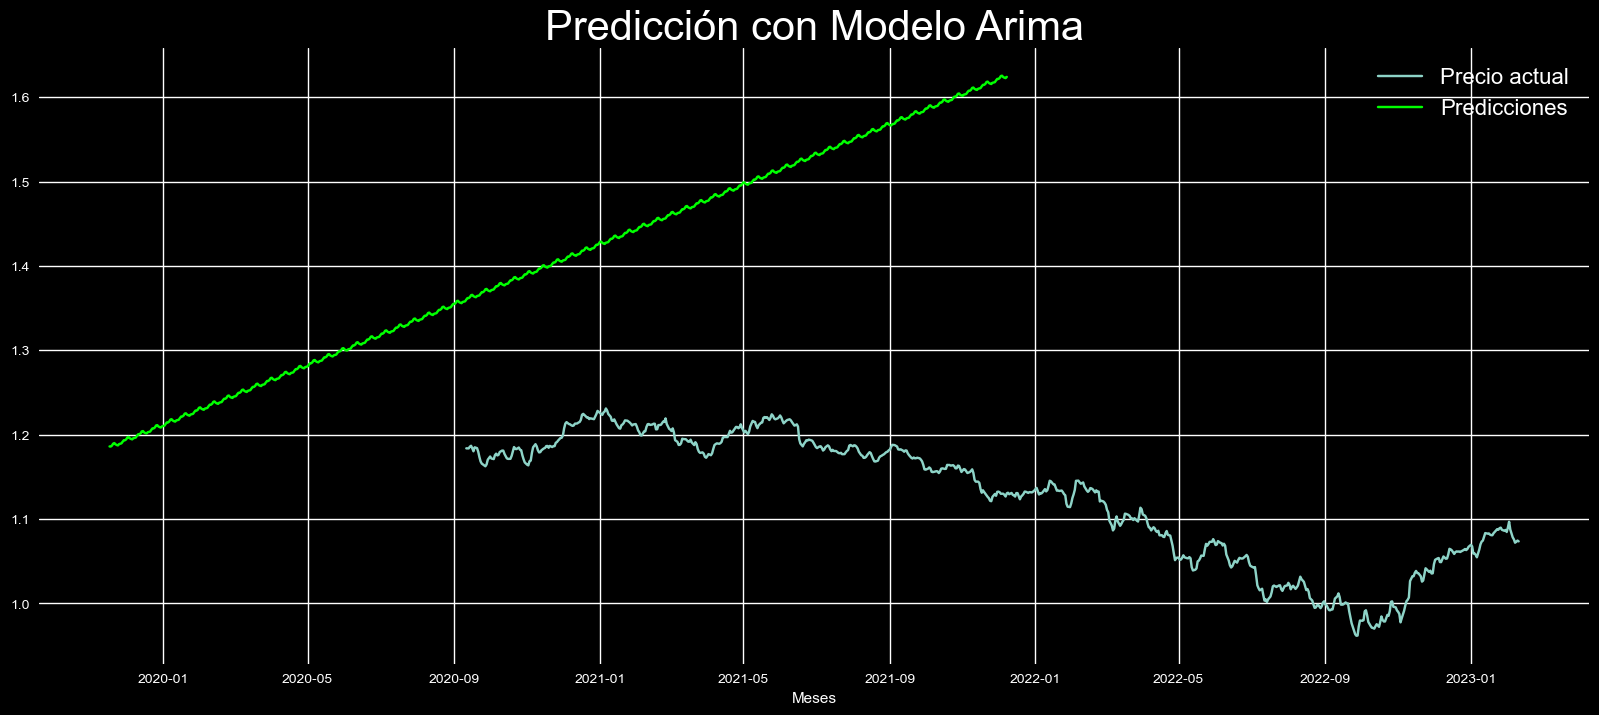

In [102]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(testing_data["open_bid"], label="Precio actual")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Encontrando valor de parámetro "q"

Para encontrar los valores de "q" podemos usar el gráfico de ACF, dicha gráfica nos dice cuanto promedio móvil se requiere para eliminar la autocorrelación de la serie de tiempo estacionaria. 

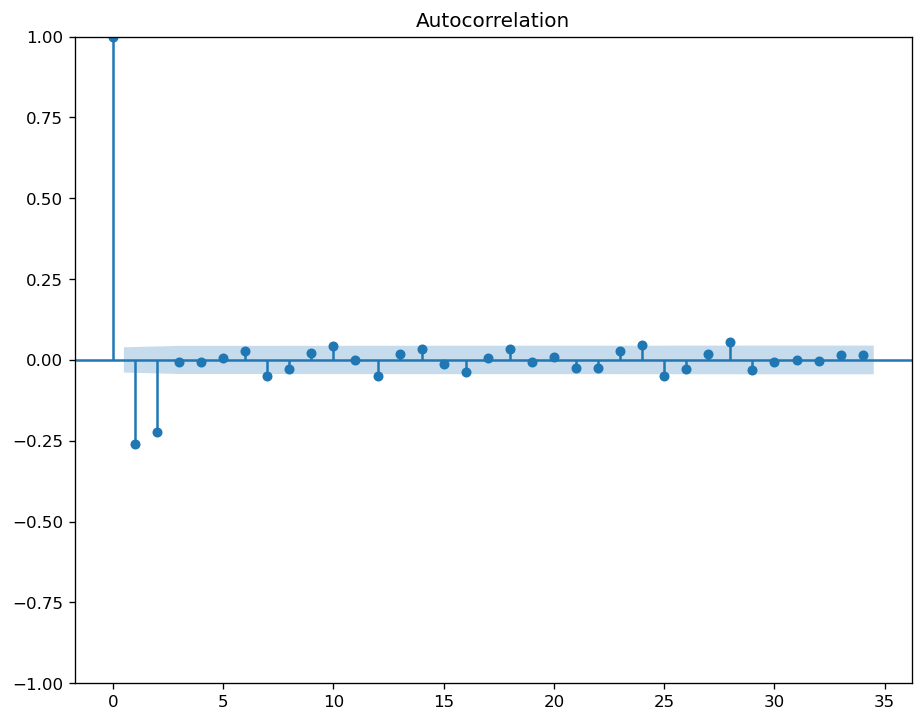

In [42]:
plot_acf(returns.open_bid.diff().dropna());

Aquí vemos que sólo 1 de los "lags" se encuentra fuera del límite de significancia , por lo que el valor óptimo de "q" es 1. 

primer argumento mas grande que 1

In [43]:
# Para construir un iterador que haga las predicciones 
for i in range(n_test_obser):
    # Vamos a comenzar con valores de p,d y q, 
    # Luego podemos usar Auto Arima  model
    model = ARIMA(train_data, order = (1,3,2))
    model_fit = model.fit()
    y_pred= model_fit.forecast()
    ## y_pred = output
    # print(y_pred)
    model_predictions.append(y_pred)
    # cambiar nombre luego para variable y_actual
    actual_y = test_data[i]
    # Para mantener actualizado el conjunto de train con la data histórica 
    train_data.append(actual_y)

NameError: name 'n_test_obser' is not defined

In [45]:
# Vamos a comenzar con valores de p,d y q, 
# Luego podemos usar Auto Arima  model
model = ARIMA(train_data, order = (3,1,2))
model_fit = model.fit()
y_pred= model_fit.forecast(len(test_data))
## y_pred = output
# print(y_pred)
# model_predictions.append(y_pred)
# cambiar nombre luego para variable y_actual
# actual_y = test_data[i]
# Para mantener actualizado el conjunto de train con la data histórica 
# train_data.append(actual_y)

model = ARIMA(train_data, order = (100,0,2)) -- buena
model = ARIMA(train_data, order = (175,0,2)) -- 

In [46]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1754
Model:                 ARIMA(3, 1, 2)   Log Likelihood                7366.942
Date:                Tue, 21 Mar 2023   AIC                         -14721.884
Time:                        21:16:34   BIC                         -14689.070
Sample:                             0   HQIC                        -14709.755
                               - 1754                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2961      1.214     -0.244      0.807      -2.675       2.083
ar.L2          0.0983      0.388      0.254      0.800      -0.662       0.858
ar.L3         -0.0518      0.133     -0.388      0.698      -0.313       0.210
ma.L1         -0.2051      1.211     -0.169      0.866      -2.579       2.169
ma.L2         -0.5106      0.990     -0.516      0.606      -2.451       1.430
sigma2      1.309e-05   2.83e-07     46.168      0.000    1.25e-05    1.36e-05
===================================================================================
Ljung-Box (L1) (Q):                   5.41   Jarque-Bera (JB):               850.56
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# print(len(model_predictions))
print(len(test_data))
print(len(y_pred))

752
752


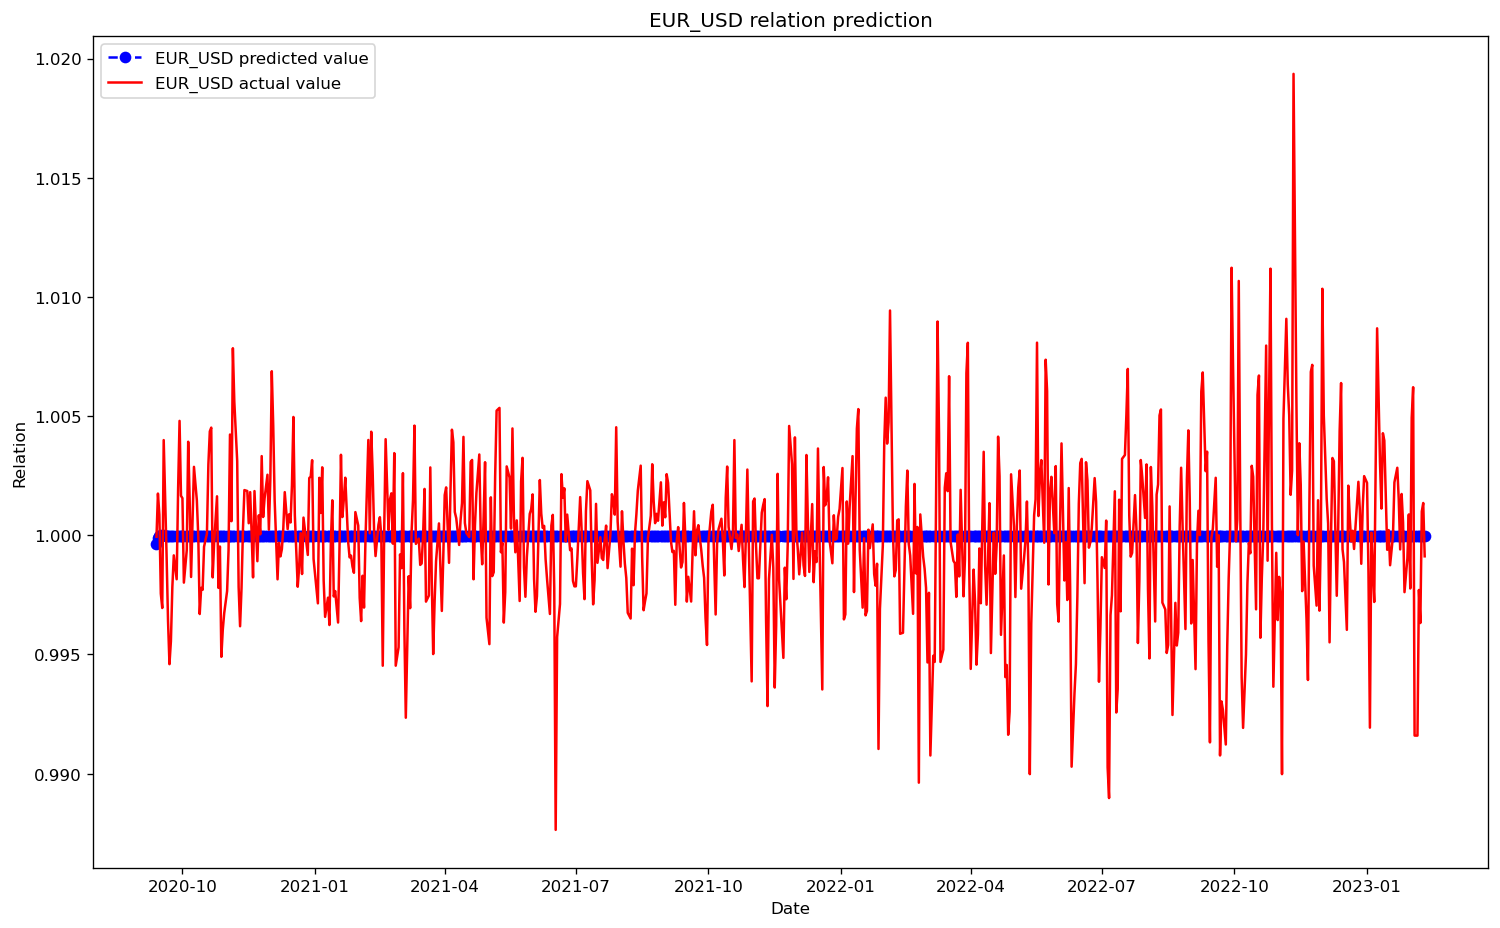

In [52]:
plt.figure(figsize=(15,9))
plt.grid=(True)

date_range = returns[particion_datos:].index

plt.plot(date_range, y_pred, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'EUR_USD predicted value')
plt.plot(date_range, test_data, color = 'red', label = 'EUR_USD actual value')

plt.title('EUR_USD relation prediction')
plt.xlabel('Date')
plt.ylabel('Relation')
plt.legend()
plt.show()

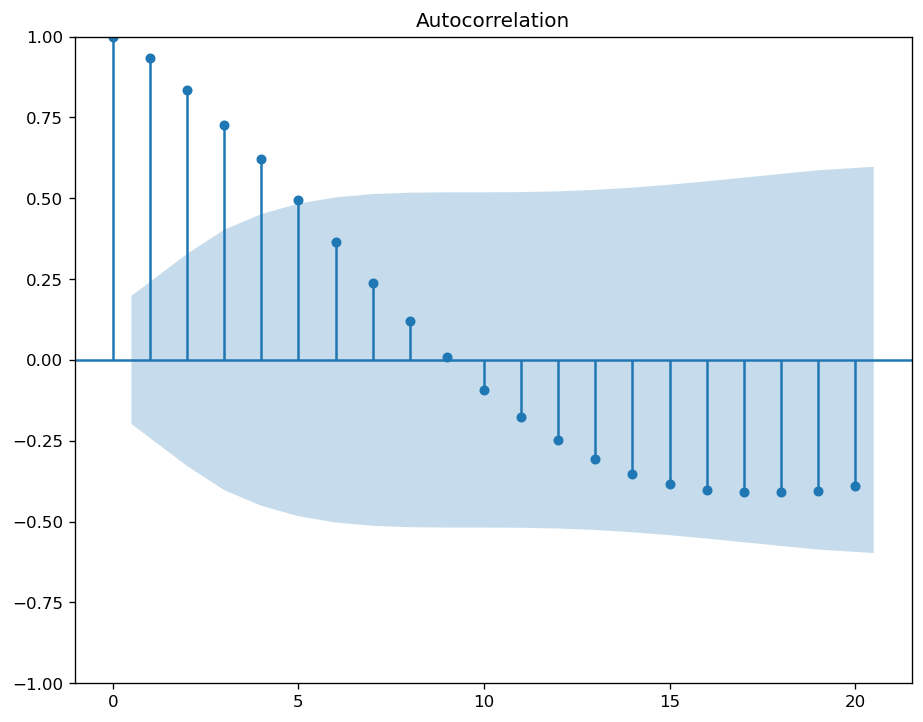

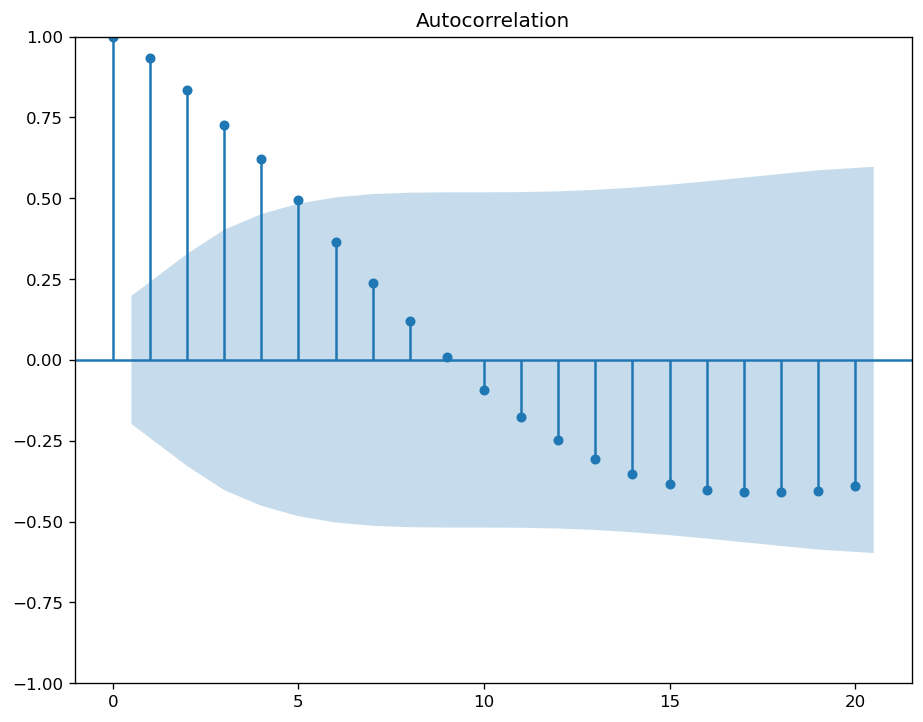

In [31]:
# Para elegir p, d, y q para ARIMA

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(exchange_rate.open_bid)

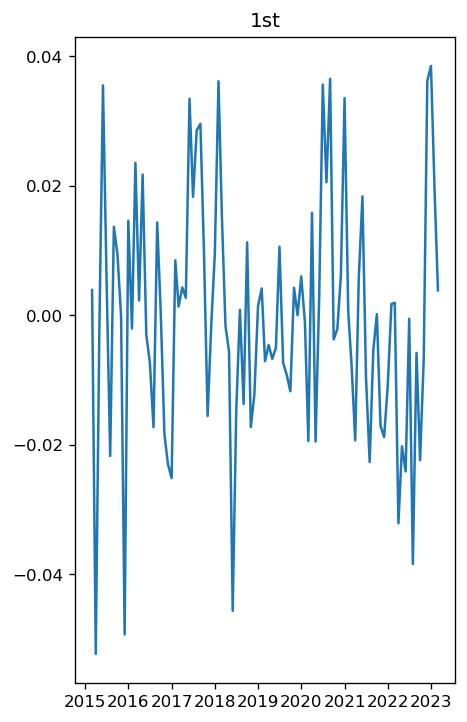

In [32]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st')
ax1.plot(exchange_rate.open_bid.diff())

In [33]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(exchange_rate.open_bid, order = (1,1,2))
model = arima_model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               open_bid   No. Observations:                   98
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 252.513
Date:                Mon, 20 Mar 2023   AIC                           -497.026
Time:                        22:24:23   BIC                           -486.727
Sample:                    01-31-2015   HQIC                          -492.862
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7285      0.387     -1.883      0.060      -1.487       0.030
ma.L1          1.0267      0.354      2.897      0.004       0.332       1.721
ma.L2          0.3089      0.107      2.887      0.0

In [34]:
with open

SyntaxError: expected ':' (2413100560.py, line 1)